## 异常检测 - iForest

In [383]:
import numpy as np
import pandas as pd
import time as time
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

#### 训练集（未经标准化）

In [384]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

In [385]:
train_data

,Unnamed: 0,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no,attack_cat,label
0,0,0.115937,72,74,4238,63516,1250.679227,31,29,2.884325e+05,...,False,True,False,False,False,False,False,False,Normal,0
1,1,0.257944,8,12,424,8824,73.659402,31,29,1.150637e+04,...,False,True,False,False,False,False,False,False,Normal,0
2,2,0.000007,2,0,900,0,142857.140900,254,0,5.142857e+08,...,False,False,True,False,False,False,False,False,Normal,0
3,3,0.052844,60,62,3614,50036,2289.758573,31,29,5.380365e+05,...,False,True,False,False,False,False,False,False,Normal,0
4,4,0.001032,2,2,146,178,2906.976908,31,29,5.658915e+05,...,False,False,False,False,False,False,False,False,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62404,62404,0.331636,10,6,2086,268,45.230311,254,252,4.530268e+04,...,False,True,False,False,False,False,False,False,Normal,0
62405,62405,0.500887,10,6,534,268,29.946876,254,252,7.682372e+03,...,False,True,False,False,False,False,False,False,Normal,0
62406,62406,0.001625,4,4,544,304,4307.692219,31,29,2.008615e+06,...,False,False,False,False,False,False,False,False,Normal,0
62407,62407,1.344894,10,8,2516,354,12.640401,254,252,1.347318e+04,...,False,True,False,False,False,False,False,False,Normal,0


In [386]:
test_data

,Unnamed: 0,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no,attack_cat,label
0,0,0.600851,6,2,978,86,1.165014e+01,62,252,1.085128e+04,...,False,False,False,False,False,False,False,False,Normal,0
1,1,0.000944,2,2,130,162,3.177966e+03,31,29,5.508474e+05,...,False,False,False,False,False,False,False,False,Normal,0
2,2,0.001040,2,2,146,178,2.884615e+03,31,29,5.615384e+05,...,False,False,False,False,False,False,False,False,Normal,0
3,3,1.052931,10,10,804,1152,1.804487e+01,62,252,5.500835e+03,...,False,True,False,False,False,False,False,False,Normal,0
4,4,0.000005,2,0,200,0,2.000000e+05,254,0,1.600000e+08,...,False,False,True,False,False,False,False,False,Analysis,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22597,22597,0.000003,2,0,114,0,3.333333e+05,254,0,1.520000e+08,...,False,False,True,False,False,False,False,False,Generic,1
22598,22598,0.000001,2,0,104,0,1.000000e+06,254,0,4.160000e+08,...,False,False,True,False,False,False,False,False,Fuzzers,1
22599,22599,0.617895,60,14,68199,612,1.181430e+02,254,252,8.682769e+05,...,False,True,False,False,False,False,False,False,Normal,0
22600,22600,0.000007,2,0,168,0,1.428571e+05,254,0,9.600000e+07,...,False,False,True,False,False,False,False,False,Reconnaissance,1


In [387]:
y_train = train_data["label"].values
attributes = train_data.iloc[:, 1:-2]

In [388]:
attributes.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.115937,72,74,4238,63516,1250.679227,31,29,2.884325e+05,4.323590e+06,...,False,False,False,True,False,False,False,False,False,False
1,0.257944,8,12,424,8824,73.659402,31,29,1.150637e+04,2.508762e+05,...,False,False,False,True,False,False,False,False,False,False
2,0.000007,2,0,900,0,142857.140900,254,0,5.142857e+08,0.000000e+00,...,False,False,False,False,True,False,False,False,False,False
3,0.052844,60,62,3614,50036,2289.758573,31,29,5.380365e+05,7.452729e+06,...,False,False,False,True,False,False,False,False,False,False
4,0.001032,2,2,146,178,2906.976908,31,29,5.658915e+05,6.899225e+05,...,False,True,False,False,False,False,False,False,False,False


In [389]:
attributes = attributes.astype(np.float32)

In [390]:
attributes.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.115937,72.0,74.0,4238.0,63516.0,1250.679199,31.0,29.0,2.884325e+05,4.323590e+06,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.257944,8.0,12.0,424.0,8824.0,73.659401,31.0,29.0,1.150637e+04,2.508762e+05,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000007,2.0,0.0,900.0,0.0,142857.140625,254.0,0.0,5.142857e+08,0.000000e+00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.052844,60.0,62.0,3614.0,50036.0,2289.758545,31.0,29.0,5.380365e+05,7.452729e+06,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001032,2.0,2.0,146.0,178.0,2906.976807,31.0,29.0,5.658915e+05,6.899225e+05,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [391]:
isolation_forest = IsolationForest()
start_time = time.time()
isolation_forest.fit(attributes)
end_time = time.time()
print("Running Time:", end_time - start_time, "seconds")

Running Time: 0.2656383514404297 seconds


In [392]:
scores = isolation_forest.decision_function(attributes)
scores = max(scores) - scores

In [393]:
fpr, tpr, thresholds = roc_curve(y_train, scores, pos_label=1)
auc_score = auc(fpr, tpr)

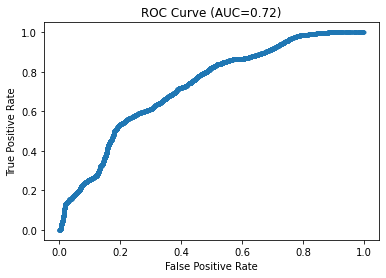

In [394]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC={:.2f})'.format(auc_score))
plt.show()

In [395]:
print("AUROC of training data:", auc_score)

AUROC of training data: 0.7246499410103746


In [396]:
precision, recall, thresholds = precision_recall_curve(y_train, scores, pos_label=1)
auprc = auc(recall, precision)

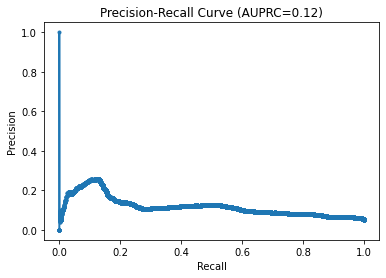

In [397]:
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPRC={:.2f})'.format(auprc))
plt.show()

In [398]:
print("AUPRC of training data:", auprc)

AUPRC of training data: 0.11801781444856466


#### 测试集（未经标准化）

In [399]:
y_test = test_data["label"].values
test_attr = test_data.iloc[:, 1:-2]
test_attr = test_attr.astype(np.float32)
test_attr.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.600851,6.0,2.0,978.0,86.0,11.650143,62.0,252.0,1.085128e+04,572.521301,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000944,2.0,2.0,130.0,162.0,3177.966064,31.0,29.0,5.508474e+05,686440.687500,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001040,2.0,2.0,146.0,178.0,2884.615479,31.0,29.0,5.615384e+05,684615.375000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.052931,10.0,10.0,804.0,1152.0,18.044868,62.0,252.0,5.500835e+03,7878.958984,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000005,2.0,0.0,200.0,0.0,200000.000000,254.0,0.0,1.600000e+08,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [400]:
test_start = time.time()
test_predictions = isolation_forest.predict(test_attr)
test_end = time.time()
print("Running Time:", test_end - test_start, "seconds")

Running Time: 0.1179351806640625 seconds


In [401]:
scores = isolation_forest.decision_function(test_attr)
scores = max(scores) - scores

In [402]:
fpr, tpr, thresholds = roc_curve(y_test, scores, pos_label=1)
auc_score = auc(fpr, tpr)

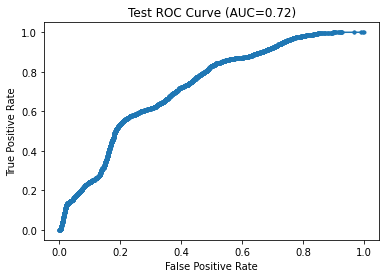

In [403]:
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve (AUC={:.2f})'.format(auc_score))
plt.show()

In [404]:
print("AUROC of test data:", auc_score)

AUROC of test data: 0.7231477303514292


In [405]:
precision, recall, thresholds = precision_recall_curve(y_test, scores, pos_label=1)
auprc = auc(recall, precision)

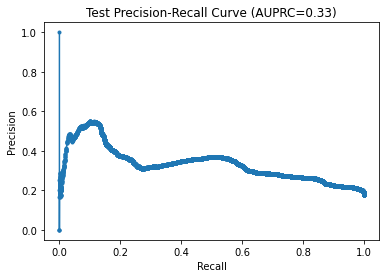

In [406]:
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Precision-Recall Curve (AUPRC={:.2f})'.format(auprc))
plt.show()

In [407]:
print("AUPRC of test data:", auprc)

AUPRC of test data: 0.33266609302840805
